In [1]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.generator import generate_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# LTN
from nltk.sem.logic import Expression
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

In [2]:
Expression.fromstring("t11")

<IndividualVariableExpression t11>

## Data Processing

In [3]:
data = pd.DataFrame(generate_dataset(100))

In [4]:
image_paths = [item for item in data[0]]
images = []
for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        
labels = torch.tensor(data[1], dtype=torch.float32)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        # Convert the list of images to a tensor and permute dimensions to [batch_size, channels, height, width]
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label
    
batch_size = 25

# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(images,labels, test_size=0.2, random_state=42)

# Create the training dataset
train_dataset = ImageDataset(train_data, train_labels)

# Create the test dataset
test_dataset = ImageDataset(test_data, test_labels)

# Create the training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_24005/3823677747.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_24005/3823677747.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels).float()


In [6]:
labels

tensor([2., 1., 1., 1., 2., 1., 1., 1., 2., 2., 2., 1., 2., 0., 2., 2., 1., 2.,
        1., 2., 1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2., 2., 1., 2., 2., 1.,
        2., 1., 2., 2., 1., 2., 1., 2., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 1., 2., 1., 2., 1., 2., 2., 2., 1., 1., 2., 2., 2.,
        2., 1., 2., 2., 1., 2., 2., 2., 1., 2., 2., 1., 2., 2., 2., 1., 2., 2.,
        1., 1., 2., 2., 2., 2., 2., 1., 1., 2.])

In [7]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of test labels: {len(test_labels)}")

Number of training images: 80
Number of training labels: 80
Number of test images: 20
Number of test labels: 20


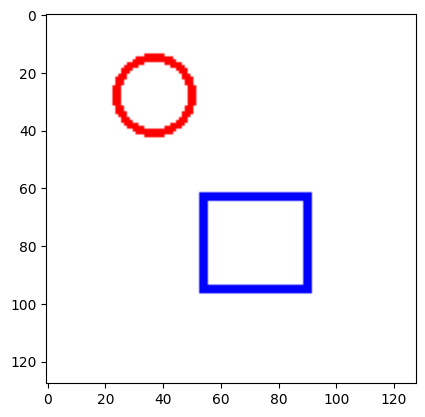

In [8]:
plt.imshow(train_data[0].numpy().astype(np.uint8))

## Models

In [9]:
class CircleDetector(torch.nn.Module):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)  # Adjusted in_features to 16384
        self.fc2 = nn.Linear(in_features=128, out_features=3)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        c_x, c_y, r = x[:,0], x[:,1], x[:,2]
        return c_x, c_y, r

In [10]:
class RectangleDetector(torch.nn.Module):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)  # Adjusted in_features to 16384
        self.fc2 = nn.Linear(in_features=128, out_features=4)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        t_x, t_y,b_x, b_y = x[:,0], x[:,1], x[:,2], x[:,3]
        return t_x, t_y, b_x, b_y

## Rules

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BoundingBox(nn.Module):
    def __init__(self):
        super(BoundingBox, self).__init__()

    def forward(self, c1, c2, r, t21=None, t22=None, b21=None, b22=None):
        if t21 is None and t22 is None and b21 is None and b22 is None:
            t21 = c1 - r
            t22 = c2 - r
            b21 = c1 + r
            b22 = c2 + r
            return t21, t22, b21, b22
        else:
            t21_check = 1 - torch.tanh(torch.abs(t21 - (c1 - r)))**2
            t22_check = 1 - torch.tanh(torch.abs(t22 - (c2 - r)))**2
            b21_check = 1 - torch.tanh(torch.abs(b21 - (c1 + r)))**2
            b22_check = 1 - torch.tanh(torch.abs(b22 - (c2 + r)))**2
            return t21_check * t22_check * b21_check * b22_check

    def __call__(self, *args):
        return self.forward(*args)

class Inside(nn.Module):
    def __init__(self):
        super(Inside, self).__init__()

    def forward(self, t11, t12, b11, b12, t21, t22, b21, b22):
        smooth_lt_t11_t21 = torch.sigmoid(10 * (t21 - t11))
        smooth_lt_t12_t22 = torch.sigmoid(10 * (t22 - t12))
        smooth_lt_b11_b21 = torch.sigmoid(10 * (b21 - b11))
        smooth_lt_b12_b22 = torch.sigmoid(10 * (b22 - b12))
        return smooth_lt_t11_t21 * smooth_lt_t12_t22 * smooth_lt_b11_b21 * smooth_lt_b12_b22

    def __call__(self, *args):
        return self.forward(*args)

class Outside(nn.Module):
    def __init__(self):
        super(Outside, self).__init__()

    def forward(self, t11, t12, b11, b12, t21, t22, b21, b22):
        smooth_gt_t11_t21 = torch.sigmoid(10 * (t11 - t21))
        smooth_gt_t12_t22 = torch.sigmoid(10 * (t12 - t22))
        smooth_gt_b11_b21 = torch.sigmoid(10 * (b11 - b21))
        smooth_gt_b12_b22 = torch.sigmoid(10 * (b12 - b22))
        return smooth_gt_t11_t21 * smooth_gt_t12_t22 * smooth_gt_b11_b21 * smooth_gt_b12_b22

    def __call__(self, *args):
        return self.forward(*args)

class Intersect(nn.Module):
    def __init__(self):
        super(Intersect, self).__init__()

    def forward(self, t11, t12, b11, b12, t21, t22, b21, b22):
        smooth_lt_t11_t21 = torch.sigmoid(10 * (t21 - t11))
        smooth_lt_t12_t22 = torch.sigmoid(10 * (t22 - t12))
        smooth_lt_b11_b21 = torch.sigmoid(10 * (b21 - b11))
        smooth_lt_b12_b22 = torch.sigmoid(10 * (b22 - b12))
        smooth_gt_t11_t21 = torch.sigmoid(10 * (t11 - t21))
        smooth_gt_t12_t22 = torch.sigmoid(10 * (t12 - t22))
        smooth_gt_b11_b21 = torch.sigmoid(10 * (b11 - b21))
        smooth_gt_b12_b22 = torch.sigmoid(10 * (b12 - b22))
        inside = smooth_lt_t11_t21 * smooth_lt_t12_t22 * smooth_lt_b11_b21 * smooth_lt_b12_b22
        outside = smooth_gt_t11_t21 * smooth_gt_t12_t22 * smooth_gt_b11_b21 * smooth_gt_b12_b22
        return 1 - (inside + outside - inside * outside)  # Smooth approximation of NOT OR (XOR)

    def __call__(self, *args):
        return self.forward(*args)

## Training

In [12]:
# ancillary_rules = [
#     "forall c1 c2 r t21 t22 b21 b22. box(c1, c2, r, t21, t22, b21, b22) <-> (t21 = c1 - r and t22 = c2 - r and b21 = c1 + r and b22 = c2 + r)",
#     "forall t11 t12 b11 b12 t21 t22 b21 b22. in(t11, t12, b11, b12, t21, t22, b21, b22) <-> (t11 >= t21 and t12 >= t22 and b11 <= b21 and b12 <= b22)",
#     "forall t11 t12 b11 b12 t21 t22 b21 b22. out(t11, t12, b11, b12, t21, t22, b21, b22) <-> (t11 > b21 or t12 > b22 or b11 < t21 or b12 < t22)",
#     "forall t11 t12 b11 b12 t21 t22 b21 b22. int(t11, t12, b11, b12, t21, t22, b21, b22) <-> (not out(t11, t12, b11, b12, t21, t22, b21, b22) and not in(t11, t12, b11, b12, t21, t22, b21, b22))"
# ]

learning_rules = [
    "all i. ((y = in) -> (Circle(i, c1, c2, r) and Rect(i, t11, t12, b11, b12) and box(c1, c2, r, t21, t22, b21, b22) and in(t11, t12, b11, b12, t21, t22, b21, b22)))",
    "all i. ((y = int) -> (Circle(i, c1, c2, r) and Rect(i, t11, t12, b11, b12) and box(c1, c2, r, t21, t22, b21, b22) and int(t11, t12, b11, b12, t21, t22, b21, b22)))",
    "all i. ((y = out) -> (Circle(i, c1, c2, r) and Rect(i, t11, t12, b11, b12) and box(c1, c2, r, t21, t22, b21, b22) and out(t11, t12, b11, b12, t21, t22, b21, b22)))"
]

In [13]:
predicates = {
    "Circle": CircleDetector(),
    "Rect": RectangleDetector(),
    "box": BoundingBox(),
    "in": Inside(),
    "out": Outside(),
    "int": Intersect()
}

loader = LoaderWrapper(loader=train_dataloader, variables=["i"], targets=["y"])

rule_to_loader = {rule: [loader] for rule in learning_rules } 

quantifier_imp = {"forall" : "pmean_error"}

connective_imp = {"eq": "tan"}

constants = { 
    "in" : torch.tensor([0.]),
    "int" : torch.tensor([1.]),
    "out" : torch.tensor([2.]),
}

kb = KnowledgeBase(
    predicates=predicates,
    ancillary_rules=[],
    learning_rules=learning_rules,
    rule_to_data_loader_mapping=rule_to_loader,
    quantifier_impls=quantifier_imp,
    connective_impls=connective_imp,
    constant_mapping=constants
)

[ str(rule) for rule in kb.rules ]

In [ ]:
kb.optimize(num_epochs=1)

## Computation Graph and Intermediate Results

In [ ]:
kb.declarations

In [ ]:
kb.rules[0].visitor.intermediate_results

In [ ]:
batch = next(iter(test_dataloader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loader )

kb.rules[0].comp_graph(var_mapping)